# Testing
This notebook is for visualizing and evaluating the model results from the different experiments that were evaluated in the thesis.
1. The dataset is created. If not already happened, the images are split into train, validation and test set and divided into smaller image patches. The JSON files that transform the data into COCO format are generated.
2. By specifying the experiment, for which the results shall be inspected, the respective trained model weights are downloaded and the configuration for the experiment is set.
3. Different options for visualizing the inference results are presented.
4. The model can be evaluated on one of the subsets.

## 0: Check Dependencies

In [1]:
import sys
import os
import mmcv

ROOT_DIR = os.path.abspath("..")
sys.path.append(ROOT_DIR)

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__) # should be 2.25.0

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version
print(get_compiling_cuda_version()) # should be matching Pytorch's cuda version

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
1.10.1+cu111 False
2.25.0
11.1


## 1: Create Dataset

If the following values (except for the paths) are left unchanged, image patches and JSON files are created so that all experiments barring the one that uses image patches with a minimum scale of 150 pixels (modification \[b\]) can easily be reproduced.

In [2]:
from DataInitialization import DataInitialization

# Path to the folder containing the original satellite images
INPUT_IMG_DIR = os.path.abspath("./data/Training_Images_RGB")
# Path to the folder containing the `.shp` annotations
ANNO_DIR = os.path.abspath("./data/Training_tree_polygons")
# Folder where train, val and test sets are created
IMG_DIR = os.path.dirname(INPUT_IMG_DIR)

# If sets are not created randomly, these indices mark the images belonging to the validation set
# and test set
val_images = [3, 8, 15, 16, 20, 28, 33, 35, 40, 43, 52, 60, 65, 68, 78, 79, 83, 89, 95, 98, 100, 107]
# For the reproduction of the reduced test set, the images 45, 91 and 99 need to be removed.
test_images = [5, 7, 17, 18, 24, 30, 41, 45, 47, 49, 51, 59, 62, 70, 76, 77, 81, 91, 99, 104, 105, 108]

# Width and height of the image patches. If a list is passed, patches of multiple sizes are created for
# the training set. For the validation and test set, only image patches of the first size are created. 
min_width = [300, 600]
min_height = [300, 600]
# Which subsets to create. 
subsets = ['train', 'val', 'test']

# Set up initialization of the datasets. If ``force`` is False, for each subset image patches and JSON
# files are only created if they do not exist thus far. If set to true, additional image patches are
# created and JSON files are regenerated, including all image patches.
ri = DataInitialization(img_dir=INPUT_IMG_DIR,
                          img_output_dir=IMG_DIR,
                          subsets=subsets,
                          force=False)

# Method to create image patches
ri.split_crop(min_width=min_width, min_height=min_height, random_split=False, val_images=val_images, test_images=test_images)
# Method to create JSON files in COCO format
ri.load_rwanda_data(anno_dir=ANNO_DIR)
ri.load_rwanda_data(anno_dir=ANNO_DIR, load_prefix="300", subsets=['train'])

Splitting all input images into tiles of 300 x 300
Splitting train input images into tiles of 600 x 600
0 image patches created


## 2: Load Experiment for Testing
To reproduce the results of the different models evaluated in the thesis, their configurations and weights can be loaded by specifying the experiment name. A list of all the experiment_names can be generated with ``print_experiments()``.

I noticed that sometimes the weight downloads within JupyterLab from Github are very slow. Alternatively to the automatic download in JupyterLab, they can be downloaded manually from https://github.com/sbackmann/rwanda-instance/releases/tag/v2.25.0 and then need to be placed in their respective experiment directories (e.g. ./experiments/00_MaskR50_-/)

In [3]:
from ModelInitialization import ModelInitialization

ModelInitialization.print_experiments()

MaskR50_-
MaskR101_-
MaskR50_1
MaskR50_2
MaskR50_3
MaskR50_4
MaskR50_5
MaskR50_6
MaskR50_7
CascadeR50_-
CascadeR101_-
MaskR50_a
MaskR50_ab
MaskR50_ac
MaskR50_acd
MaskR50_acde
CascadeR50_acd


In [4]:
from ModelInitialization import ModelInitialization

# Specify which model shall be tested.
experiment = "MaskR50_acd"

mi = ModelInitialization(experiment=experiment)
model_dir = "./pretrained_models"

# Downloads the trained weights if not already downloaded
checkpoint = mi.load_experiment_weights()
# Loads configuration for chosen experiment
cfg = mi.load_config(anno_dir=ANNO_DIR, img_dir=IMG_DIR, checkpoint=checkpoint)

Weights already downloaded.
Loaded configuration for MaskR50_acd.


## 3: Visualize Inference Results

In [5]:
from RwandaVisualization import RwandaVisualization

v = RwandaVisualization(cfg, checkpoint, subset='val')

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


/home/jovyan/work/saved_data/mmdetection2.25/mmdetection/rwanda/RwandaVisualization.py:64: UserWarning: Warning: No cuda device found. Using CPU.
  warnings.warn("Warning: No cuda device found. Using CPU.")


load checkpoint from local path: ./experiments/13_MaskR50_acd/MaskR50_acd_epoch24.pth


### 3.1: Compare Inference Results to the Ground Truth
Plots the ground truth image patch next to the model's prediction. If no file name is specified, a random image from the subset is selected.

Image: /home/jovyan/work/saved_data/mmdetection2.25/mmdetection/rwanda/data/val/300x300_image_79_3DNW3R.tif_tile_916-2038.tif


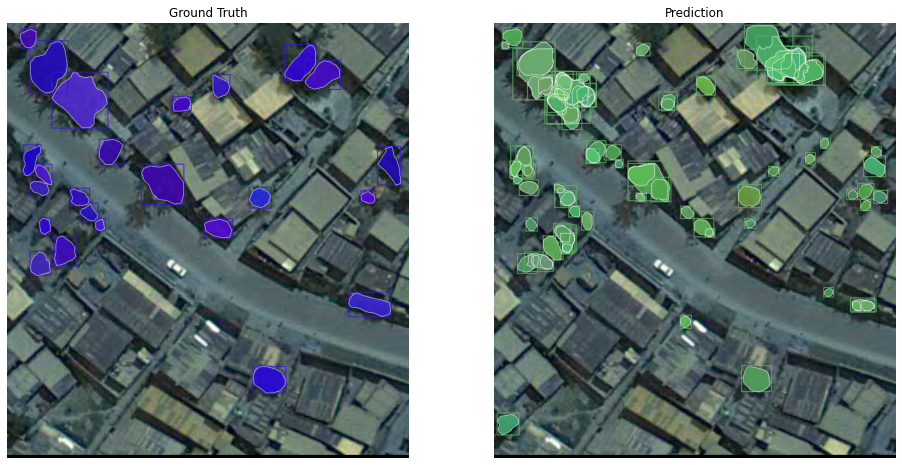

In [7]:
# Either set img to None (random image) or specify image name (this must be in the subset)
img = None  # "300x300_image_65_1CNW1R.tif_tile_0-0.tif"
v.eval_image(img=img, save_fig=False)

### 3.2: Batch Ground Truth and Inference Generation
For a large scale comparison of ground truth and inference results, all ground truth annotations and predictions can be saved into a directory for further inspection.

In [ ]:
# Specify directory (does not have to be existent) to store ground truth images. Ground truths are only created if the specified directory is empty.
ground_truth_dir = "./visualization/ground_truths"
v.save_ground_truths(out_dir=ground_truth_dir)

# Specify directory (does not have to be existent) to store inference results. Results are only created if the specified directory is empty.
inference_dir = f"./visualization/{experiment}_inference"
v.save_inference_results(out_dir=inference_dir)

Ground truth images already existing in ./visualization/ground_truths.
Saving inference results into ./visualization/MaskR50_-_inference.
[                                ] 4/368, 0.1 task/s, elapsed: 28s, ETA:  2577s

### 3.3: Show the Inference Results only
Alternatively, the full path to the image that should be inferenced can be specified. Then, only the prediction will be shown. This might be useful to test the model on new data that is neither in the train, val or test set.

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


/home/jovyan/work/saved_data/mmdetection2.25/mmdetection/rwanda/RwandaVisualization.py:147: UserWarning: Warning: No cuda device found. Using CPU.
  warnings.warn("Warning: No cuda device found. Using CPU.")


load checkpoint from local path: ./experiments/08_CascadeR50_-/CascadeR50_-_epoch7.pth


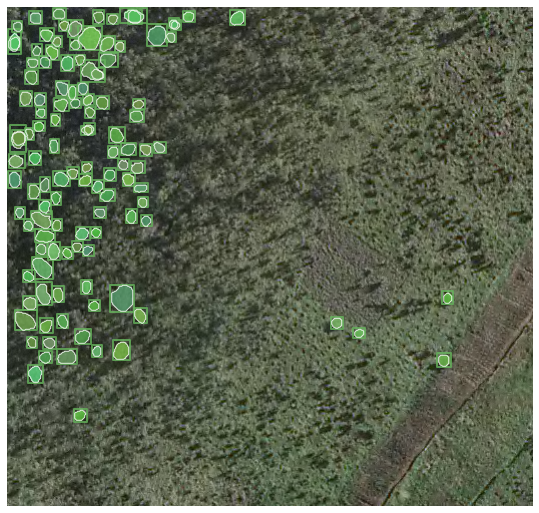

In [5]:
# Here, the full path to the image must be specified.
img = os.path.join(IMG_DIR, "val/300x300_image_65_1CNW1R.tif_tile_0-0.tif")
v.plot_inference(img)

## 4: Evaluate Model Metrics

In [6]:
from ModelEvaluation import evaluate_rwanda
# Specify out_file if the results are to be saved.
out_dir = './visualization'
evaluate_rwanda(cfg, checkpoint, subset="test", out_dir=out_dir)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


NameError: name 'checkpoint_file' is not defined

In [23]:
import os
import time
import pickle
import mmcv
from mmcv import Config, DictAction
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmdet.apis import single_gpu_test
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_dp, compat_cfg, get_device,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)


def evaluate_rwanda(config, checkpoint_file, out_file=None, subset="val",metrics=["bbox", "segm"], work_dir=None, gpu_id=0):

    if out_file is not None and not out_file.endswith(('.pkl', '.pickle')):
        raise ValueError('The output file must be a pkl file.')

    if config.endswith(('.pkl', '.pickle')):
        cfg = pickle.load(open(config,'rb'))
    else: 
        cfg = Config.fromfile(args.config)

    
    # replace the ${key} with the value of cfg.key
    cfg = replace_cfg_vals(cfg)

    # update data root according to MMDET_DATASETS
    update_data_root(cfg)

    cfg = compat_cfg(cfg)

    # set multi-process settings
    setup_multi_processes(cfg)

    # set cudnn_benchmark
    if cfg.get('cudnn_benchmark', False):
        torch.backends.cudnn.benchmark = True

    if 'pretrained' in cfg.model:
        cfg.model.pretrained = None
    elif 'init_cfg' in cfg.model.backbone:
        cfg.model.backbone.init_cfg = None

    if cfg.model.get('neck'):
        if isinstance(cfg.model.neck, list):
            for neck_cfg in cfg.model.neck:
                if neck_cfg.get('rfp_backbone'):
                    if neck_cfg.rfp_backbone.get('pretrained'):
                        neck_cfg.rfp_backbone.pretrained = None
        elif cfg.model.neck.get('rfp_backbone'):
            if cfg.model.neck.rfp_backbone.get('pretrained'):
                cfg.model.neck.rfp_backbone.pretrained = None

    cfg.gpu_ids = [gpu_id]
    cfg.device = get_device()

    test_dataloader_default_args = dict(
        samples_per_gpu=1, workers_per_gpu=2, dist=False, shuffle=False)
    cfg.data.test.ann_file = os.path.join(os.path.abspath("./data/Training_tree_polygons"), 'test_annotation_coco.json')
    cfg.data.test.img_prefix = os.path.join(os.path.abspath("./data"), 'test')
    cfg.data.test.classes = ('tree',)
    if subset == "val":
        cfg.data.test = cfg.data.val

    # in case the test dataset is concatenated
    if isinstance(cfg.data.test, dict):
        cfg.data.test.test_mode = True
        if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
            # Replace 'ImageToTensor' to 'DefaultFormatBundle'
            cfg.data.test.pipeline = replace_ImageToTensor(
                cfg.data.test.pipeline)
    elif isinstance(cfg.data.test, list):
        for ds_cfg in cfg.data.test:
            ds_cfg.test_mode = True
        if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
            for ds_cfg in cfg.data.test:
                ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

    test_loader_cfg = {
        **test_dataloader_default_args,
        **cfg.data.get('test_dataloader', {})
    }

    rank, _ = get_dist_info()
    # allows not to create
    if work_dir is not None and rank == 0:
        mmcv.mkdir_or_exist(os.path.abspath(work_dir))
        timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
        json_file = os.path.join(work_dir, f'eval_{timestamp}.json')

    # build the dataloader
    dataset = build_dataset(cfg.data.test)
    data_loader = build_dataloader(dataset, **test_loader_cfg)

    # build the model and load checkpoint
    cfg.model.train_cfg = None
    model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
    fp16_cfg = cfg.get('fp16', None)
    if fp16_cfg is not None:
        wrap_fp16_model(model)
    checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
    model.CLASSES = dataset.CLASSES


    model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)
    outputs = single_gpu_test(model, data_loader)

    rank, _ = get_dist_info()
    if rank == 0:
        if out_file:
            print(f'\nwriting results to {out_file}')
            mmcv.dump(outputs, out_file)
            
        eval_kwargs = cfg.get('evaluation', {}).copy()
        # hard-code way to remove EvalHook args
        for key in [
                'interval', 'tmpdir', 'start', 'gpu_collect', 'save_best',
                'rule', 'dynamic_intervals'
        ]:
            eval_kwargs.pop(key, None)
        kwargs = {}
        eval_kwargs.update(dict(metric=metrics, **kwargs))
        metric = dataset.evaluate(outputs, **eval_kwargs)
        print(metric)
        metric_dict = dict(config=config, metric=metric)
        if work_dir is not None and rank == 0:
            mmcv.dump(metric_dict, json_file)

In [33]:
checkpoint_file = './rwanda_exps/13_MoreAnchors_07_20_AP_15-9/epoch_24.pth'
config_file = './rwanda_exps/13_MoreAnchors_07_20_AP_15-9/cfg.pkl'
out_file = './test/test_test.pkl'
evaluate_rwanda(config_file, checkpoint_file, subset="test", out_file=out_file)

/tmp/ipykernel_1127/3581182567.py:23: ResourceWarning: unclosed file <_io.BufferedReader name='./rwanda_exps/13_MoreAnchors_07_20_AP_15-9/cfg.pkl'>
  cfg = pickle.load(open(config,'rb'))
/home/jovyan/.local/lib/python3.8/site-packages/pycocotools/coco.py:84: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/jovyan/work/saved_data/mmdetection2.25/mmdetection/rwanda/data/Training_tree_polygons/test_annotation_coco.json' mode='r' encoding='UTF-8'>
  dataset = json.load(open(annotation_file, 'r'))


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
load checkpoint from local path: ./rwanda_exps/13_MoreAnchors_07_20_AP_15-9/epoch_24.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 273/273, 6.1 task/s, elapsed: 45s, ETA:     0s
writing results to ./test/test_test.pkl

Evaluating bbox...
Loading and preparing results...
DONE (t=0.31s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=190.49s).
Accumulating evaluation results...
DONE (t=0.86s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.393
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=10

/home/jovyan/work/saved_data/mmdetection2.25/mmdetection/mmdet/datasets/coco.py:457: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(


Loading and preparing results...
DONE (t=0.56s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=192.30s).
Accumulating evaluation results...


/home/jovyan/.local/lib/python3.8/site-packages/pycocotools/cocoeval.py:381: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)


DONE (t=0.86s).

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.389
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.432

OrderedDict(